# A class to manipulate the CRUST1.0 model

This notebook shows how  to use the `Crust1` class to manipulate the [CRUST1.0 model](http://igppweb.ucsd.edu/~gabi/crust1.html). The class is defined in the [`crust1.py`](crust1.py) file.

## Load the model and make some plots

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import seaborn

In [3]:
from fatiando.vis import mpl, myv
from fatiando import gridder
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


In [5]:
from crust1 import fetch_crust1

In [6]:
model = fetch_crust1('../data/crust1.0.tar.gz')

In [7]:
model.layers

['water',
 'ice',
 'upper_sediments',
 'middle_sediments',
 'lower_sediments',
 'upper_crust',
 'middle_crust',
 'lower_crust',
 'mantle']

In [8]:
model.water.density

array([[ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       ..., 
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.],
       [ 1020.,  1020.,  1020., ...,  1020.,  1020.,  1020.]])

In [9]:
model.upper_crust.vp

array([[ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       [ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       [ 5900.,  5900.,  5900., ...,  5900.,  5900.,  5900.],
       ..., 
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.],
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.],
       [ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.]])

In [10]:
# Mean crustal density
model.density[5:8].mean(0)

array([[ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       [ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       [ 2773.33333333,  2773.33333333,  2773.33333333, ...,
         2773.33333333,  2773.33333333,  2773.33333333],
       ..., 
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667],
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667],
       [ 2816.66666667,  2816.66666667,  2816.66666667, ...,
         2816.66666667,  2816.66666667,  2816.66666667]])

In [11]:
bm = Basemap(projection='moll', lon_0=0, resolution='c')

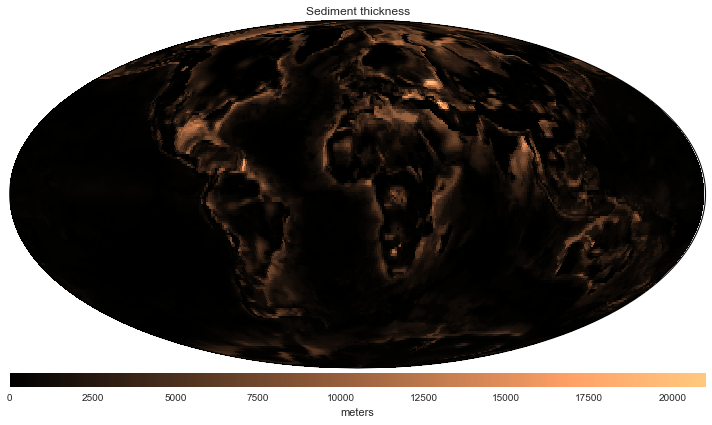

In [12]:
x, y = bm(model.lon, model.lat)

plt.figure(figsize=(10, 7))
plt.title('Sediment thickness')
bm.pcolormesh(x, y, model.sediment_thickness, cmap='copper')
plt.colorbar(pad=0.01, orientation='horizontal', aspect=50).set_label('meters')
plt.tight_layout()

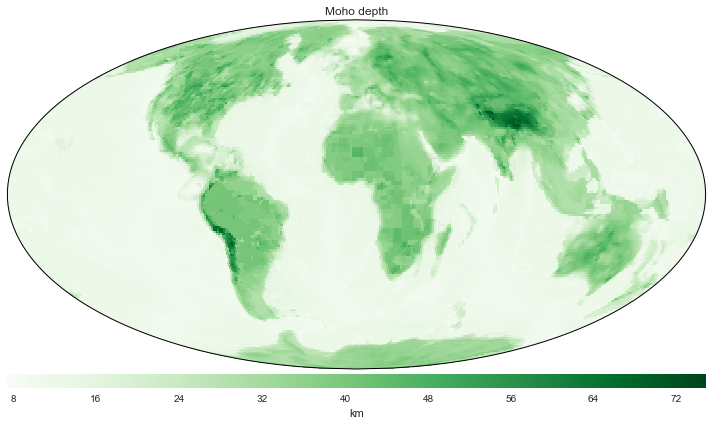

In [13]:
plt.figure(figsize=(10, 7))
plt.title('Moho depth')
bm.pcolormesh(x, y, 0.001*model.moho_depth, cmap='Greens')
plt.colorbar(pad=0.01, orientation='horizontal', aspect=50).set_label('km')
plt.tight_layout()

## Cut the model

In [14]:
sa = model.cut((-65, 20, -90, -30))

In [15]:
area = sa.area
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

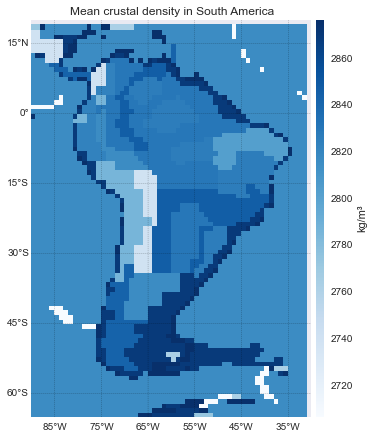

In [16]:
x, y = bm(sa.lon, sa.lat)
plt.figure(figsize=(7, 6))
plt.title('Mean crustal density in South America')
bm.pcolormesh(x, y, sa.density[5:8].mean(0), cmap='Blues')
plt.colorbar(pad=0.01, aspect=50).set_label(u'kg/m³')
bm.drawmeridians(np.arange(-85, -20, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-60, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()